In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas

In [3]:
df = pandas.read_csv('GSPC-00-19.csv')

# Volatility Modeling

**Volatility** is defined as the standard deviation(or variance) of the change in price of financial security. Modeling standard deviation rather than the pure stock prices is a better predictor because we're looking to predict how stock prices will *change*, more than the numerical value of the stocks.

The data we'll be working with looks as follows:

In [4]:
print(df.head(5))

       Time     Open     High      Low    Close  Change  Volume
0  11/04/19  3078.96  3085.20  3074.87  3078.27   11.36     0.0
1  11/01/19  3050.72  3066.95  3050.72  3066.91   29.35     0.0
2  10/31/19  3046.90  3046.90  3023.19  3037.56   -9.21     0.0
3  10/30/19  3039.74  3050.10  3028.39  3046.77    9.88     0.0
4  10/29/19  3035.39  3047.87  3034.81  3036.89   -2.53     0.0


We'll mostly be working with the closing prices. So if we wanted to see the closing price on September 19, 2008, it will be:

In [214]:
print(df['Close'][2700])
print(df['Time'][2800])

835.19
09/19/08


We first show the S&P 500 stock price data from January 3, 2000 to November 4, 2019. Note that the x-axis represents days (but there exists data for only *some* days, not all). The huge downward trend after the 2000 tick mark indicates the 2008 market crash. 

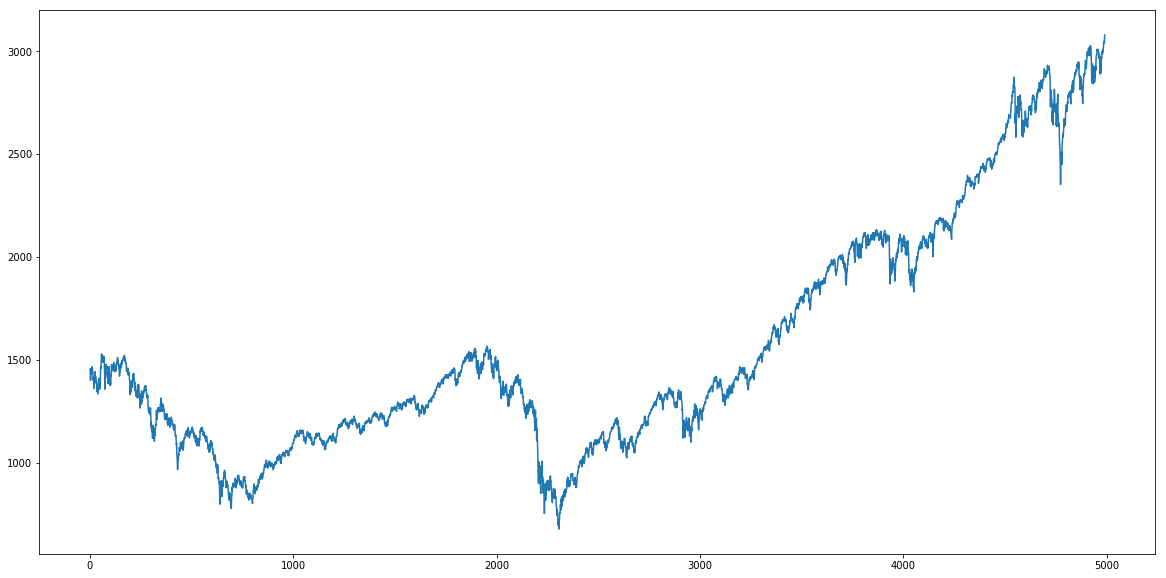

In [215]:
x = np.arange(4992)
y = df['Close'] #reverse since it's in reverse-chronological order
y = y[::-1]
plt.figure(figsize=(20,10))
plt.plot(x,y)

Because we want to predict the changes in the stock prices, if $P_t$ is the price of a stock at time $t$, we use $\log(P_t/P_{t-1})$ to represent the *returns*. Thus, although we are using the stock prices, we are really using the *returns* in our predictive models.

In [55]:
pile = [_ for _ in y]
ret_pile = []
for i in range(len(pile) - 1):
    ret_pile.append(np.log(pile[i+1] / pile[i]))

[-0.039099226875721496, 0.0019203798115278359, 0.0009552460841297421, 0.02672993526267859, 0.011127821298329016]


### Helper Functions

In [123]:
def plot(y, y_approx):
    x = range(len(y))
    plt.figure(figsize=(20,10))
    plt.plot(x,y)
    plt.plot(x,y_approx)
    plt.show()

In [103]:
def sum_error(y, y_approx):
    sum = 0
    for i in range(len(y)):
        sum += (y[i] - y_approx[i])**2
    return sum

# Moving Average (MA) Model
We have an average $\mu$ as our "baseline" and we "correct" our estimation by adding the previous error. 
$\hat{y}_t$ is the model's guess and $y_t$ is the real value of the returns at time $t$. $\alpha$ is a constant that measures the degree to which we should correct our guess due to our mistake. $\epsilon_t$ is the error at time $t$, essentially a measure of how wrong our previous prediction turned out to be.

So we have by our model that
$$\hat{y}_t = \mu + \alpha\cdot\epsilon_{t-1}.$$

As an example, this is what our model might look for $\mu = 5$ and $\alpha = 0.5$:

| $t$ 	| $\hat{y}_t$ 	| $y_t$ 	| $\epsilon_t$ 	|
|:---:	|:-----------:	|:-----:	|:------------:	|
|  1  	|      5      	|   6   	|       1      	|
|  2  	|     5.5     	|   4   	|     -1.5     	|
|  3  	|     4.25    	|   4   	|     -0.25    	|
|  4  	|     4.75    	|   5   	|     0.25     	|

In [116]:
def moving_avg(alpha):
    mu = sum(ret_pile[:100]) / 100
    f = [mu]
    for i in range(100, len(ret_pile)):
        ep = ret_pile[i] - f[-1]
        if i == len(ret_pile) - 1:
            break
        f.append(mu + (alpha * ep))
    return f

This is the graph that predicts the variance using a **moving_average(1)** model:

The blue represents the real returns while the orange represents the model's predictions.

1.418748121899004


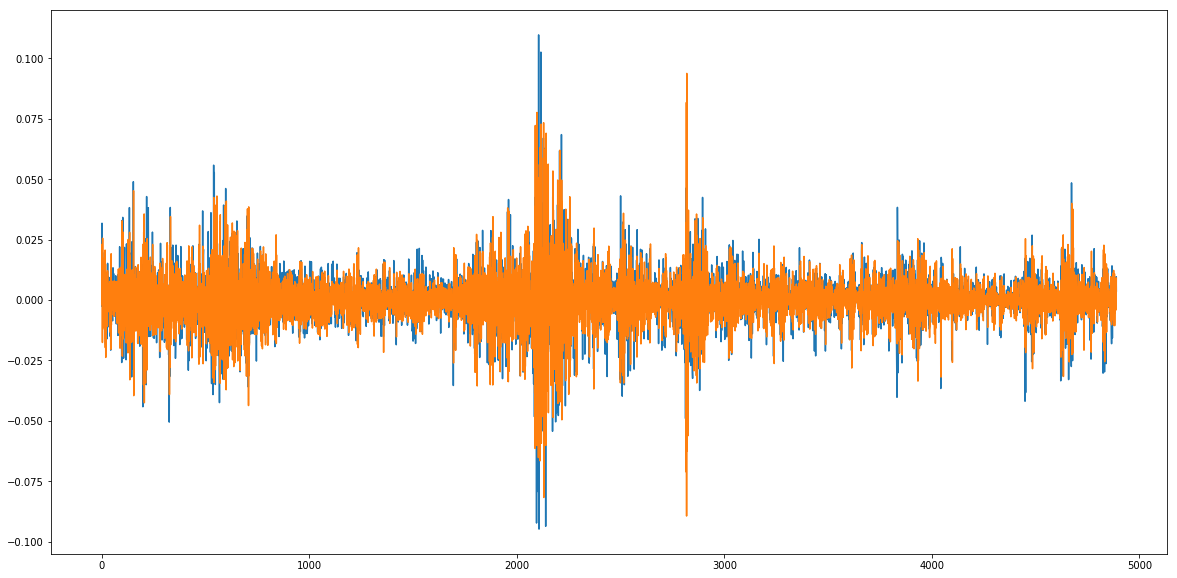

In [220]:
f_ma = moving_avg(0.7)
print(sum_error(ret_pile[100:],f_ma))
plot(ret_pile[100:], f_ma)

In [236]:
def moving_avg2(alpha1, alpha2):
    mu = sum(ret_pile[:100]) / 100
    f = [mu]
    ep = [ret_pile[100] - mu]
    f.append(mu + 0.5*ep[0])
    for i in range(100, len(pile)):
        ep.append(ret_pile[i] - f[-1])
        if i == len(ret_pile) - 2:
            break
        f.append(mu + (alpha1 * ep[-1]) + (alpha2 * ep[-2]))
    return f

This is the graph that predicts the variance using a **moving_average(2)** model:

The blue represents the real returns while the orange represents the model's predictions.

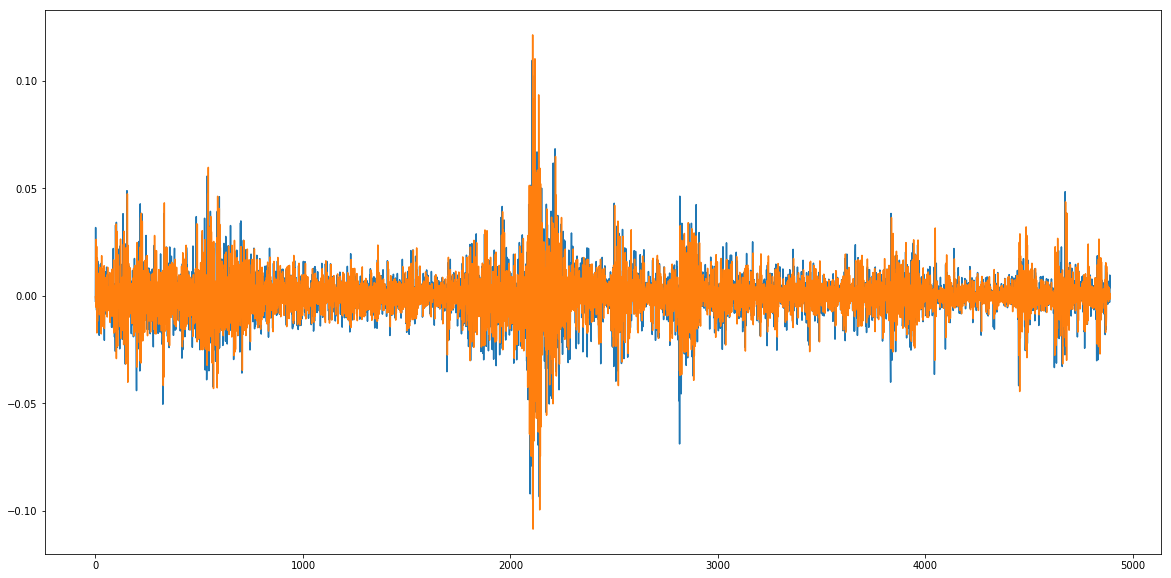

1.4091527304679883


In [237]:
f_ma2 = moving_avg2(0.8,0.5)
plot(ret_pile[100:], f_ma2)
print(sum_error(ret_pile[100:], f_ma2))

# ARCH(p) Model

**A**uto **R**egressive **C**onditional **H**eteroskedascticity

* Auto Regressive means prediction(regression) based on past values of itself(auto)
* Volatility(Heteroskedasciticity) is not constant(conditional) and based on previous data (unlike Black-Scholes)

We’re essentially predicting future error by assuming that it is correlated with past error. An ARCH model may be good in cases where the magnitude of the volatility is similar among close time periods.

Let $y_t = \log(P_t/P_{t-1})$ be the returns of a stock at time $t$. Then we have that the ARCH$(p)$ model is given by the following:

$$ \hat{y_t} = \mu + \epsilon_t $$
$$ \epsilon_t = z_t \cdot \sqrt{\alpha_1 \cdot \epsilon_{t-1} + \cdots + \alpha_p \cdot \epsilon_{t-p}} $$

where $z_t$ is white noise with mean 0 and variance 1. Thus, we can see that we have modeled on top of the moving average model.

In [127]:
def arch1(alpha, beta1):
    mu = sum(ret_pile[:100]) / 100
    f = [mu]
    ep = [ret_pile[100] - f[-1]]
    for i in range(100, len(ret_pile)):
        ep_guess = np.random.normal(0,1) * np.sqrt(beta1*(ep[-1]**2))
        if i == len(ret_pile) - 1:
            break
        f.append(mu + (alpha*ep_guess))
        ep.append(ret_pile[i+1] - f[-1])
    return f

In [126]:
def arch2(alpha, beta1, beta2):
    mu = sum(ret_pile[:100]) / 100
    f = [mu]
    ep = [ret_pile[100] - f[-1]]
    for i in range(100, len(ret_pile)):
        if i == 100:
            ep_guess = np.random.normal(0,1) * np.sqrt(beta1*(ep[-1]**2))
        else:
            ep_guess = np.random.normal(0,1) * np.sqrt(beta1 * (ep[-1]**2) + beta2*(ep[-2]**2))
        if i == len(ret_pile) - 1:
            break
        f.append(mu + (alpha*ep_guess))
        ep.append(ret_pile[i+1] - f[-1])
    return f

## Results for ARCH(p)
This is the graph that predicts the variance in stock prices using the following models:
* ARCH(1)
* ARCH(2)

The blue represents the real returns while the orange represents the model's predictions.

In [128]:
f1 = arch1(0.9, 0.5)
f2 = arch2(0.9, 0.5, 0.3)
print(sum_error(ret_pile[100:], f1))
print(sum_error(ret_pile[100:], f2))

1.0823621101816023
2.0730350121489067


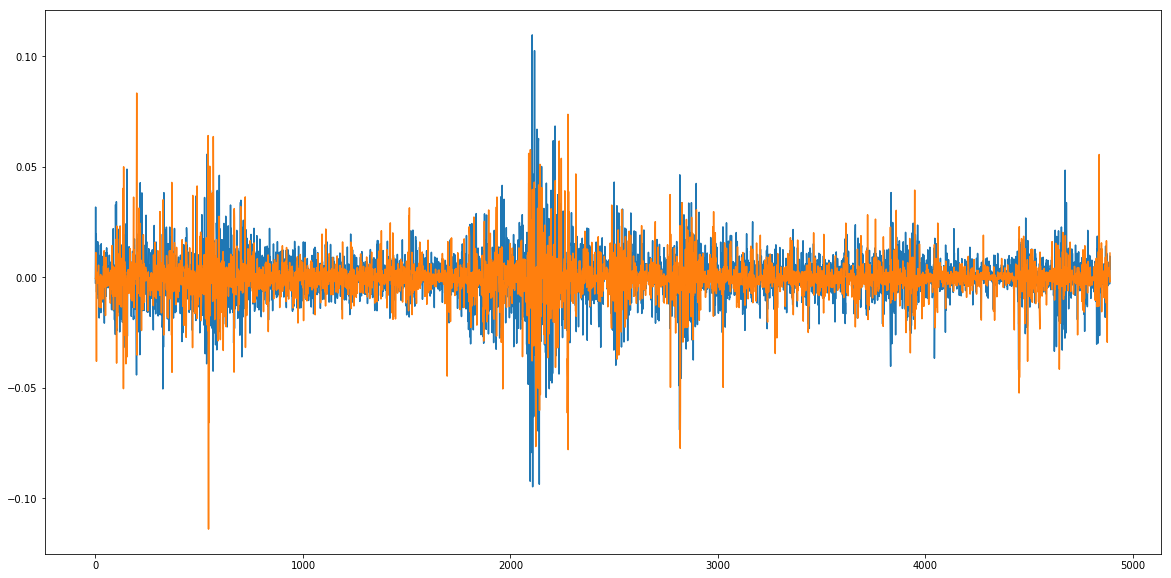

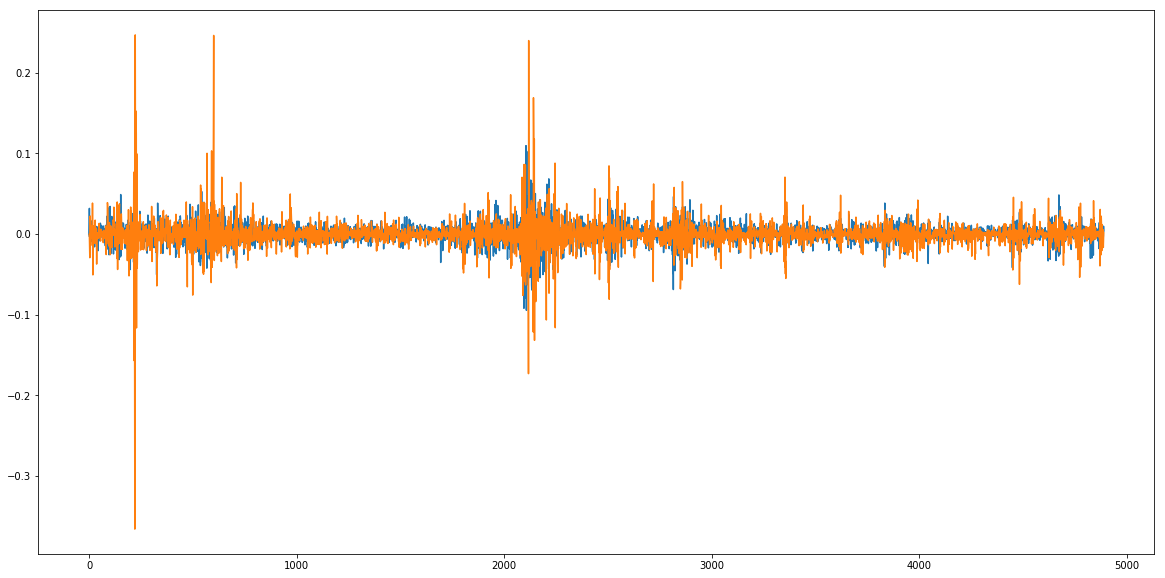

In [124]:
plot(ret_pile[100:], f1)
plot(ret_pile[100:], f2)

## ARMA (1,1)

A simple version of the Auto-Regressive Moving Average Model.

$$ X_t = c + \epsilon_t + \sum_{i=1}^p \beta_i X_{t-i} + \sum_{i=1}^q \phi_i \epsilon_{t-i} $$

In [140]:
def arma(beta, phi):
    f = [ret_pile[99]]
    for i in range(100, len(ret_pile)):
        ep = ret_pile[i] - f[-1]
        if i == len(ret_pile) - 1:
            break
        f.append((beta * ret_pile[i]) + (phi * ep))
    return f

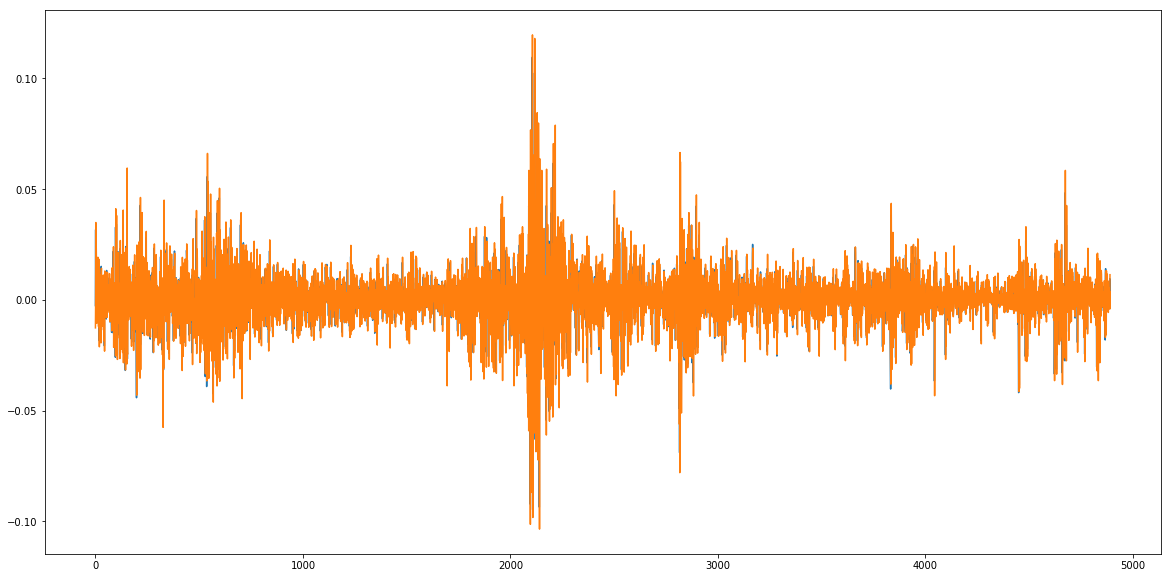

In [185]:
plot(ret_pile[100:],arma(0.9, 0.2))

### Some additional tests

Since it's hard to see how well the returns are doing, let's look at the actual closing prices.

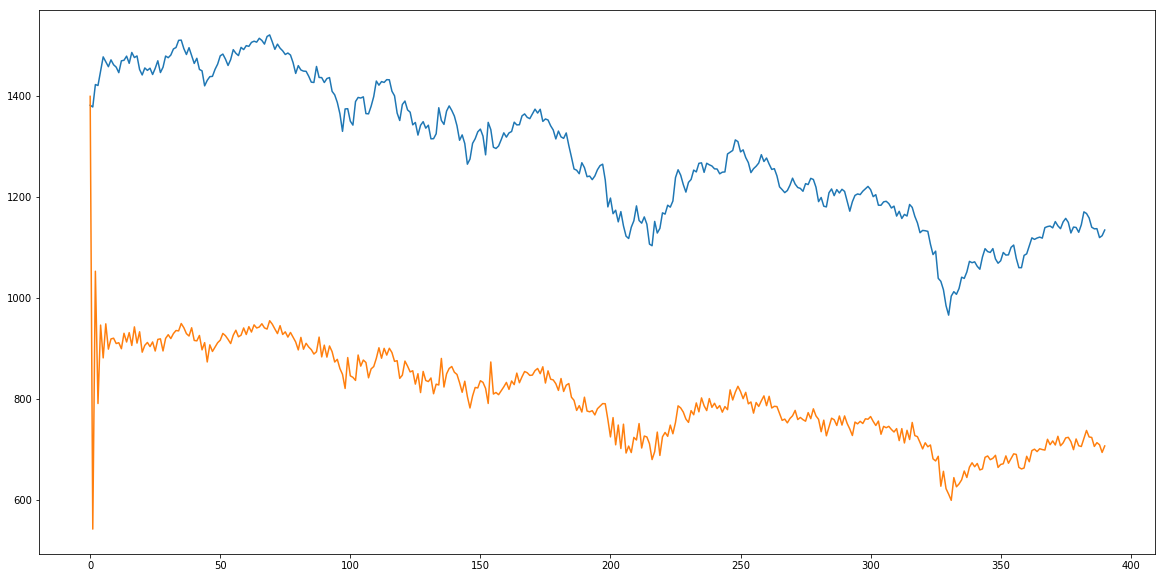

In [197]:
beta = 0.4
phi = 0.6
f = [pile[99]]
k = 4500
for i in range(100, len(pile) - k):
    ep = pile[i] - f[-1]
    if i == len(pile) - 1 - k:
        break
    f.append((beta * pile[i]) + (phi * ep))

plot(pile[100:len(pile) - k],f)

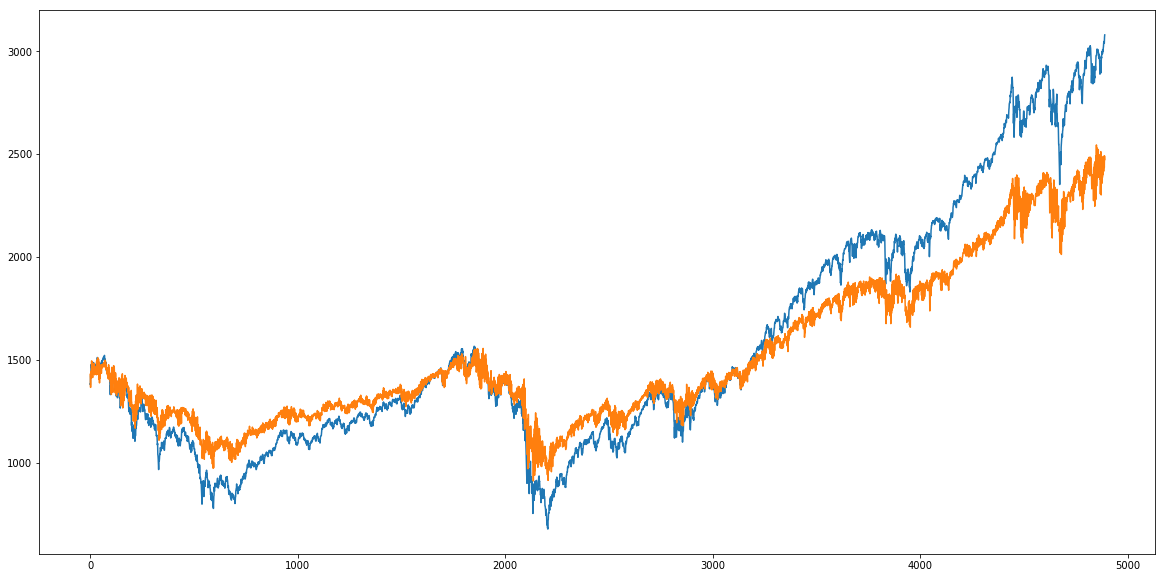

In [196]:
mu = sum(pile[:100]) / 100
f = [mu]
alpha1 = 0.9
alpha2 = 0.9
ep = [pile[100] - mu]
f.append(mu + 0.5*ep[0])
for i in range(100, len(pile)):
    ep.append(pile[i] - f[-1])
    if i == len(pile) - 2:
        break
    f.append(mu + (alpha1 * ep[-1]) + (alpha2 * ep[-2]))
plot(pile[100:], f)

In [ ]:
mu = sum(pile[:100]) / 100
f = [mu]
alpha1 = 0.9
alpha2 = 0.9
ep = [pile[100] - mu]
f.append(mu + 0.5*ep[0])
for i in range(100, len(pile)):
    ep_guess = np.random.normal(0,1) * np.sqrt(alpha1*(ep[-1]**2))
    if i == len(pile) - 2:
        break
    f.append(mu + (alpha1 * ep[-1]) + (alpha2 * ep[-2]))
    ep.append(pile[i] - f[-1])
plot(pile[100:], f)

mu = sum(pile[:100]) / 100
f = [mu]
ep = [pile[100] - f[-1]]
for i in range(100, len(pile)):
    ep_guess = np.random.normal(0,1) * np.sqrt(0.1*(ep[-1]**2))
    if i == len(pile) - 1:
        break
    f.append(mu + (alpha*ep_guess))
    ep.append(pile[i+1] - f[-1])
plot(pile[100:], f)

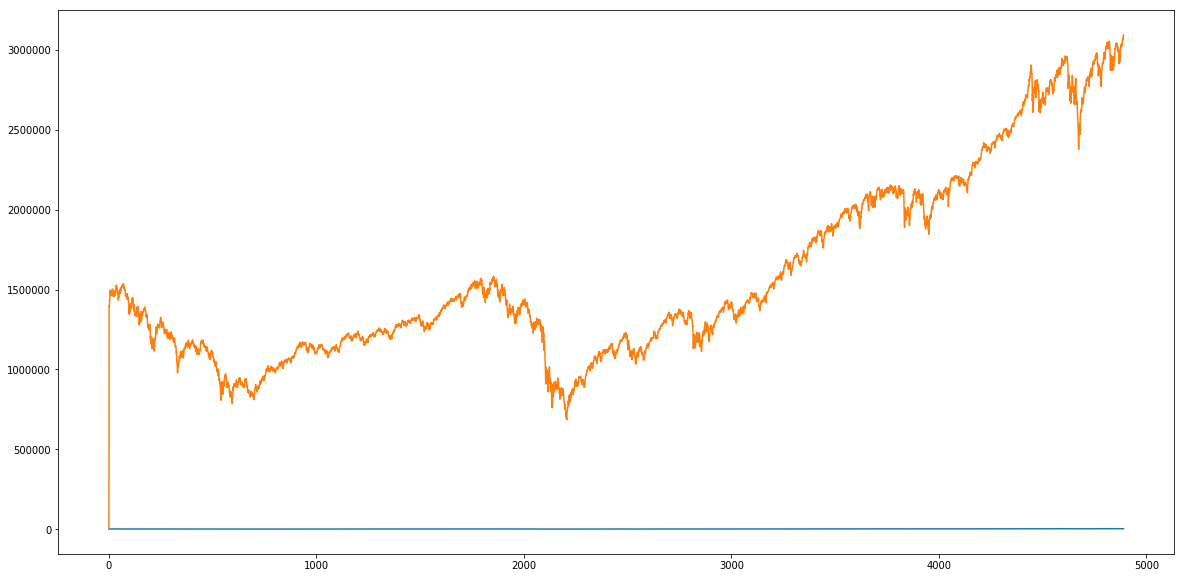

In [209]:
mu = sum(pile[:100]) / 100
f = [mu]
ep = [pile[100] - f[-1]]
for i in range(100, len(pile)):
    ep_guess = np.random.normal(mu,1) * np.sqrt(0.5*(pile[i]**2))
    if i == len(pile) - 1:
        break
    f.append(mu + ep_guess)
plot(pile[100:], f)